In [1]:
import copy
import time
import os
sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Librispeech Dataset

In [2]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("librispeech-train-other-500") 
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s"


 Loaded librispeech-train-other-500


In [3]:
speaker_mfcc_db.shape, mfcc_channel_db.shape

((364642, 2), (364642, 13))

Count number of unique speakers

In [4]:
len(np.unique(speaker_mfcc_db["speaker_id"]))

1166

Count the number of samples for each speaker_id

In [5]:
speaker_mfcc_db.groupby('speaker_id').size().sort_values()

speaker_id
449      33
421      42
680      50
689      61
974      66
       ... 
827     382
114     382
399     382
1162    382
746     382
Length: 1166, dtype: int64

Text(0, 0.5, 'number of saples')

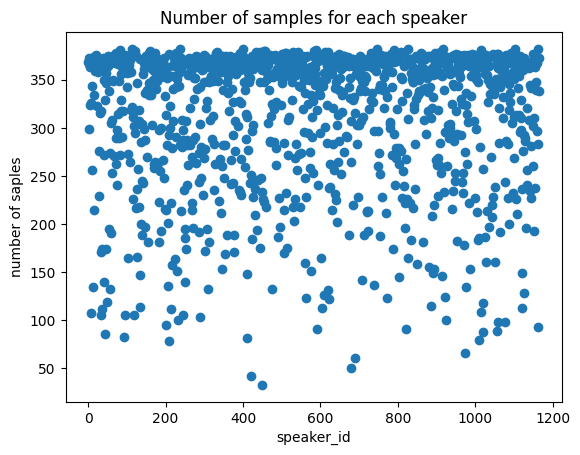

In [6]:
plt.scatter(speaker_mfcc_db.groupby('speaker_id').size().sort_values().index, speaker_mfcc_db.groupby('speaker_id').size().sort_values().values)
plt.title('Number of samples for each speaker')
plt.xlabel('speaker_id')
plt.ylabel('number of saples')

**We can decide what speaker_ids to keep in our dataset based on the number of samples**.

e.g. if we want at least 100 samples per speaker to have enough for training, validation, test (60, 20, 20)

In [7]:
min_num_samples = 100
speaker_mfcc_db_subset = speaker_mfcc_db[speaker_mfcc_db["speaker_id"].isin(speaker_mfcc_db.groupby('speaker_id').size()[speaker_mfcc_db.groupby('speaker_id').size() >= min_num_samples].index)]
number_speaker_ids = len(np.unique(speaker_mfcc_db_subset["speaker_id"]))

print(f"{number_speaker_ids} speakers in this subset, each with at least {min_num_samples} samples")

1148 speakers in this subset, each with at least 100 samples


In [8]:
mfcc_ids_subset = speaker_mfcc_db_subset["mfcc_id"].values
mfcc_channel_db_subset = mfcc_channel_db[mfcc_channel_db.index.isin(mfcc_ids_subset)]

## Preprocessing

In [9]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [10]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [11]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [12]:
def get_datasets(speaker_mfcc_db, mfcc_channel_db, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(train_ids)]
    speaker_mfcc_db_val = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(val_ids)]
    speaker_mfcc_db_test = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(test_ids)]
    
    mfcc_channel_db_train = mfcc_channel_db.loc[train_ids]
    mfcc_channel_db_val = mfcc_channel_db.loc[val_ids]
    mfcc_channel_db_test = mfcc_channel_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [13]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db_subset['speaker_id']))


In [14]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db_subset, mfcc_channel_db_subset,
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:38<00:00,  2.97s/it]


In [15]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
train_size, val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()

In [17]:
print(train_size)
print(val_size)

217480
72647


Custom Net Training Function

In [18]:
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_size 
        avg_train_acc = train_acc/train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/val_size 
        avg_valid_acc = valid_acc/val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history



def plotting(history):
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    ep = []
    i = 0
    for tloss,vloss, tacc, vacc in history:
        train_acc.append(tacc)
        val_acc.append(vacc)
        train_loss.append(tloss)
        val_loss.append(vloss)
        ep.append(i)
        i += 1


    n = len(train_loss) # number of epochs
    plt.figure()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    # plt.show()

    plt.figure()
    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

In [ ]:
#Transfer Learning

In [20]:
#Define CustomNet
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 251, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [24]:
#Load pre trained parameters
model = torch.load(r'C:\Users\David\clone\audio-speaker-recognition\notebooks\net.pth')
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

In [25]:
model.classifier.add_module("7",nn.Linear(251, 1148))
model.classifier.add_module("8", nn.LogSoftmax(dim = 1))
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

In [26]:
model = model.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(model, epochs=10, batch_size = 45, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_14708\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.